# Experimento

O objetivo desse experimento é propor classificadores de
texto para classificar mensagens de fóruns de discussão com
base na anotação produzida pelas ontologias produzidas por [1].

Os dados apresentam 295 amostras de mensagens de fóruns
de discussão e são anotados com base na teoria do diálogo
freireano. As amostras são classificadas nas categorias Afetividade, Valorização da autonomia e Reflexividade crítica. Vale
ressaltar que cada amostra pode apresentar a presença de zero
ou mais categorias. 

O problema foi simplificado e transformado em um problema binário com a categória Valorização da autonomia.

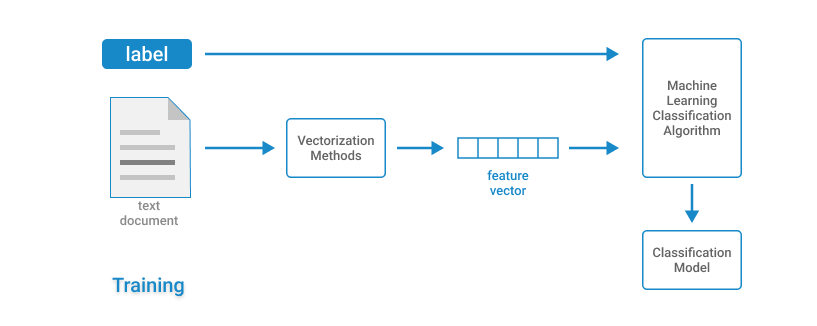

### Vetorização do texto

- O Bag of Words (BoW) consiste em simplesmente definir a frequência em que cada palavra do seu vocabuláro inteiro estão presentes em cada frase. Onde o vocabulario é o conjunto de todas as palvras distintas que você vai considerar nessa base de dados, usualmente sendo as palavras distintas na base de treinamento.
    
- O TF-IDF pondera as palavras mais importantes. Basicamente, essa técnica permite que a representação vetorial tenha um peso com base da frequência em que as palavras aparecem em todas as frases da base, ou seja, uma palavra que está presente em todas as frases da base, não carrega informação, e portanto terá um peso baixo.

- Sentença-BERT (SBERT) é uma modificação da rede BERT pré-treinada padrão que usa redes siamesas e trigêmeas para criar incorporações de sentenças para cada sentença que podem ser comparadas usando uma similaridade de cosseno, tornando viável a busca semântica para um grande número de sentenças (requerendo apenas alguns segundos de tempo de treinamento).



### Técnicas auxiliares
- Stopwords: são palavras que podem ser consideradas irrelevantes. Exemplos: as, e, os, de, para, com, sem, foi.
- <strike>Stemming</strike>: Analisa-se cada palavra individualmente e reduz à sua raiz.
- Lemmatization: Também busca-se reduzir a palavra à sua raiz, retirando todas as inflexões e chegando ao lemma. Porém, essa redução sempre resultará em uma palavra que realmente existe na gramática

### EDA 
Forma do dataset após codificação:
    
- TF-IDF (295, 4559) (sem pré-processamento, esse número pode diminuir pela metade com).
- SBERT (295, 512).

Nuvem de Palavras.
    

### Treinamento
- Aplicação da metodologia 5x2cv teste pareado.
- Comparação de dois modelos XGBoost utilizando diferentes tipos de codificação/vetorização. 
- Métrica utilizada: F1 Score (Macro). 


### Avaliação estatística
- Teste T pareado

### Instalação de depedências

In [ ]:
!pip install xgboost==1.7.1

In [ ]:
!pip install mlxtend
!pip install -U imbalanced-learn
!pip install nltk
!pip install spacy_sentence_bert
!pip install spacy
!python -m spacy download pt

2022-12-16 09:53:38.445581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-12-16 09:53:38.445801: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-16 09:53:52.634986: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-16 09:53:52.642724: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: vostro-romes
2022-12-16 09:53:52.642943: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: vostro-romes


[!] As of spaCy v3.0, shortcuts like 'pt' are deprecated. Please use the full
pipeline package name 'pt_core_news_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [ ]:
!pip install wordcloud

### Importação de bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import spacy_sentence_bert
from copy import deepcopy
from sklearn.metrics import accuracy_score
import nltk
import spacy
import re
import string
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
from sentence_transformers import SentenceTransformer, util
from sklearn.ensemble import RandomForestClassifier

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('rslp')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\sr_ro\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sr_ro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sr_ro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Leitura dos dados


In [ ]:
data = pd.read_csv('autonomia.csv')
data

,Conteúdo,Presença total,Presença parcial,Ausência,Indefinido
0,"Olá a todos, Adorei a leitura da aula 4 - Tut...",NaN,NaN,sim,NaN
1,Professor Kelsen e Companheiros de Curso.Bom d...,NaN,sim,NaN,NaN
2,Muito bem Silveira. Quais são as atribuições d...,NaN,sim,NaN,NaN
3,Quais são as atribuições dos tutores a distânc...,NaN,sim,NaN,NaN
4,"Kelsen e colegas,Iniciando os estudos dessa au...",NaN,NaN,sim,NaN
...,...,...,...,...,...
290,O uso das mídias digitais no processo educativ...,NaN,NaN,sim,NaN
291,Postei as considerações sobre a utilização das...,NaN,NaN,sim,NaN
292,"Isso mesmo Cristófilo, principalmente, porque ...",NaN,sim,NaN,NaN
293,"Ainda temos realmente essa barreira Marciana, ...",NaN,NaN,sim,NaN


### Modelagem dos dados para a classificação binária

In [ ]:
data['class'] = 1

In [ ]:
data.loc[data['Ausência'] == "sim", 'class'] = 0
data.loc[data['Indefinido'] == "sim", 'class'] = 0

In [ ]:
data.drop(['Presença total', 'Presença parcial', 'Ausência', 'Indefinido'], axis=1, inplace=True)

In [ ]:
data

,Conteúdo,class
0,"Olá a todos, Adorei a leitura da aula 4 - Tut...",0
1,Professor Kelsen e Companheiros de Curso.Bom d...,1
2,Muito bem Silveira. Quais são as atribuições d...,1
3,Quais são as atribuições dos tutores a distânc...,1
4,"Kelsen e colegas,Iniciando os estudos dessa au...",0
...,...,...
290,O uso das mídias digitais no processo educativ...,0
291,Postei as considerações sobre a utilização das...,0
292,"Isso mesmo Cristófilo, principalmente, porque ...",1
293,"Ainda temos realmente essa barreira Marciana, ...",0


In [ ]:
# descartar valores nulos
data.dropna(inplace=True)
data.isna().sum()

Conteúdo    0
class       0
dtype: int64

In [ ]:
data['class'].value_counts()

1    181
0    114
Name: class, dtype: int64

In [ ]:
181/295

0.6135593220338983

In [ ]:
114/295

0.3864406779661017

In [ ]:
data.shape

(295, 2)

In [ ]:
print(data.loc[[0]])

                                            Conteúdo  class
0  Olá a todos,  Adorei a leitura da aula 4 - Tut...      0


### Pré-processamento

Nessa etapa, é aplicado duas técnicas de pré-processamento para otimização dos dados para os modelos: remoção de stop words e lemmatization (lematização). Além disso, dígitos e pontuação foram removidas.

In [ ]:
nlp = spacy.load('pt_core_news_sm')

In [ ]:
def pre_processing(data):
    data = data.apply(lambda x: re.sub('\w*\d\w*','', x))
    data = data.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
    data = data.apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
    
    return data

In [ ]:
data['lemma_and_sw'] = data['Conteúdo'].apply(lambda x: re.sub('\w*\d\w*','', x))
data['lemma_and_sw']

0      Olá a todos,  Adorei a leitura da aula  - Tuto...
1      Professor Kelsen e Companheiros de Curso.Bom d...
2      Muito bem Silveira. Quais são as atribuições d...
3      Quais são as atribuições dos tutores a distânc...
4      Kelsen e colegas,Iniciando os estudos dessa au...
                             ...                        
290    O uso das mídias digitais no processo educativ...
291    Postei as considerações sobre a utilização das...
292    Isso mesmo Cristófilo, principalmente, porque ...
293    Ainda temos realmente essa barreira Marciana, ...
294    Muito interessante a idéia de trabalhar com os...
Name: lemma_and_sw, Length: 295, dtype: object

In [ ]:
data['lemma_and_sw'] = data['lemma_and_sw'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
data['lemma_and_sw']

0      Olá a todos  Adorei a leitura da aula   Tutori...
1      Professor Kelsen e Companheiros de CursoBom di...
2      Muito bem Silveira Quais são as atribuições do...
3       Quais são as atribuições dos tutores a distância
4      Kelsen e colegasIniciando os estudos dessa aul...
                             ...                        
290    O uso das mídias digitais no processo educativ...
291    Postei as considerações sobre a utilização das...
292    Isso mesmo Cristófilo principalmente porque po...
293    Ainda temos realmente essa barreira Marciana p...
294    Muito interessante a idéia de trabalhar com os...
Name: lemma_and_sw, Length: 295, dtype: object

In [ ]:
data['lemma_and_sw'] = data['lemma_and_sw'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [ ]:
data['lemma_and_sw']

0      Olá   Adorei leitura aula    Tutoria Educação ...
1      professor Kelsen Companheiros CursoBom diaMal ...
2                    Silveira atribuição tutor distância
3                             atribuição tutor distância
4      Kelsen colegasIniciando estudo aula papel tuto...
                             ...                        
290    uso mídia digital processo educativo somar mod...
291    Postar consideração utilização ferramenta menc...
292    Cristófilo principalmente utilizar necessidade...
293    realmente barreira marciana aluno curso Matemá...
294    interessante idéia trabalhar dispositivo móvel...
Name: lemma_and_sw, Length: 295, dtype: object

In [ ]:
data['lemma_and_sw'][0]

'Olá   Adorei leitura aula    Tutoria Educação Distância Algunspontos chamar atenção   fato professortutor simplesmente tutor crescer muitono EAD atuação limitar recursosdisponível época hoje haver pensar EAD focarna figura tutor   base fundamental êxito modalidadede ensino   tutor limitar fundamentação teórico capacidadetécnica excelência precisar sobretudo humanizar sistemaatravés emoção participaçãodo incentivo ação pedagógico emocionar encantar aluno verdade coloquei naprimeiro aulo tutor maestro orquestra EADPerceber demanr valorizar esforçosensinar   fato distância significar distanciamento doprocesso aprendizagem Distância físico caber aotutor função imprescindível mediação distância físico senãosuprimer diminuída comunicação efetivo particular constante    encanteime carta professor percepçãoenquanto tutor EADYzy câmara'

In [ ]:
data['lemma_and_sw'].shape

(295,)

In [ ]:
_X_ = data['lemma_and_sw'].to_numpy()
_X_.shape

(295,)

In [ ]:
tfidf = TfidfVectorizer()
_X_tf = tfidf.fit_transform(_X_)
_X_tf.shape

(295, 3918)

In [ ]:
tfidf = TfidfVectorizer()
_X_tf = tfidf.fit_transform(data['Conteúdo'].to_numpy())
_X_tf.shape

(295, 4559)

### EDA 

#### Nuvem de palavras

In [ ]:
stopwords = nltk.corpus.stopwords.words('portuguese')
text = " ".join(s for s in data['Conteúdo'])
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=1600, height=800).generate(text)

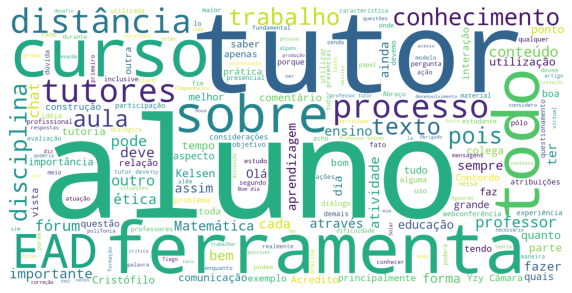

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);
wordcloud.to_file("summary_wordcloud.png")

### Divisão das amostras com base nas labels

<AxesSubplot:>

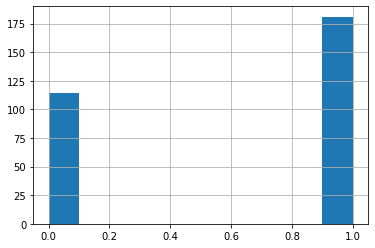

In [ ]:
data['class'].hist()

### Vetorização de texto

In [ ]:
tfidf = TfidfVectorizer()

In [ ]:
sbert = SentenceTransformer('distiluse-base-multilingual-cased-v1')

### Método 5x2cv 

Esse método considera dois estimadores  para uma tarefa supervisionada (classificadores ou regressores). Normalmente, utiliza-se a divisão dos dados do tipo _hold-out_ (treino e teste). No teste t pareado 5x2cv é realizado também uma divisão em duas partes, porém a divisão - 50% para o conjunto de treino e 50% para o conjunto de teste - é repetida 5 vezes [3].

In [ ]:
from scipy import stats
from sklearn.metrics import get_scorer
from sklearn.model_selection import KFold, train_test_split

def paired_ttest_5x2cv_(estimator1, estimator2, X, y, scoring=None, random_seed=None):
    """
    Implements the 5x2cv paired t test proposed
    by Dieterrich (1998)
    to compare the performance of two models.
    Parameters
    ----------
    estimator1 : scikit-learn classifier or regressor
    estimator2 : scikit-learn classifier or regressor
    X : {array-like, sparse matrix}, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape = [n_samples]
        Target values.
    scoring : str, callable, or None (default: None)
        If None (default), uses 'accuracy' for sklearn classifiers
        and 'r2' for sklearn regressors.
        If str, uses a sklearn scoring metric string identifier, for example
        {accuracy, f1, precision, recall, roc_auc} for classifiers,
        {'mean_absolute_error', 'mean_squared_error'/'neg_mean_squared_error',
        'median_absolute_error', 'r2'} for regressors.
        If a callable object or function is provided, it has to be conform with
        sklearn's signature ``scorer(estimator, X, y)``; see
        http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
        for more information.
    random_seed : int or None (default: None)
        Random seed for creating the test/train splits.
    Returns
    ----------
    t : float
        The t-statistic
    pvalue : float
        Two-tailed p-value.
        If the chosen significance level is larger
        than the p-value, we reject the null hypothesis
        and accept that there are significant differences
        in the two compared models.
    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/
    """
    
    scores_est1 = []
    scores_est2 = []
    rng = np.random.RandomState(random_seed)

    if scoring is None:
        if estimator1._estimator_type == "classifier":
            scoring = "accuracy"
        elif estimator1._estimator_type == "regressor":
            scoring = "r2"
        else:
            raise AttributeError("Estimator must " "be a Classifier or Regressor.")
    if isinstance(scoring, str):
        scorer = get_scorer(scoring)
    else:
        scorer = scoring

    variance_sum = 0.0
    first_diff = None

    def score_diff(X_1, X_2, y_1, y_2):
        tfidf = TfidfVectorizer() 
        sbert = SentenceTransformer('distiluse-base-multilingual-cased-v1')
        
        # conj. treino
        X_1_tf = pre_processing(X_1)
        X_1_tf = tfidf.fit_transform(X_1_tf.to_numpy()).toarray()
        print(X_1_tf.shape)

        X_1_sb = sbert.encode(X_1.to_numpy())
        print(X_1_sb.shape)
       
        # conj. teste
        X_2_tf = pre_processing(X_2)
        X_2_tf = tfidf.transform(X_2_tf.to_numpy()).toarray()
        X_2_sb = sbert.encode(X_2.to_numpy())
        print(X_2_tf.shape)
        print(X_2_sb.shape)


        
        # treinamento
        estimator1.fit(X_1_tf, y_1)
        estimator2.fit(X_1_sb, y_1)
    
        # avaliação
        est1_score = scorer(estimator1, X_2_tf, y_2)
        est2_score = scorer(estimator2, X_2_sb, y_2)
        
        scores_est1.append(est1_score)
        scores_est2.append(est2_score)
        
        # cálculo da diferença
        score_diff = est1_score - est2_score
        return score_diff

    for i in range(5):
        randint = rng.randint(low=0, high=32767)
        X_1, X_2, y_1, y_2 = train_test_split(X, y, test_size=0.5, random_state=randint, stratify=y)

        score_diff_1 = score_diff(X_1, X_2, y_1, y_2)
        score_diff_2 = score_diff(X_2, X_1, y_2, y_1)
        score_mean = (score_diff_1 + score_diff_2) / 2.0
        score_var = (score_diff_1 - score_mean) ** 2 + (score_diff_2 - score_mean) ** 2
        variance_sum += score_var
        if first_diff is None:
            first_diff = score_diff_1

    numerator = first_diff
    denominator = np.sqrt(1 / 5.0 * variance_sum)
    t_stat = numerator / denominator

    pvalue = stats.t.sf(np.abs(t_stat), 5) * 2.0
    return float(t_stat), float(pvalue), scores_est1, scores_est2

### Extreme Gradient Boosting (XGBoost): Comparação entre TF-IDF e SBERT

In [ ]:
# instância do modelo
xgb = XGBClassifier(random_state=11)

# é preciso instanciar um novo modelo fazendo uma cópia
# para que as informações do treinamento não sejam sobrescritas
xgb_2 = deepcopy(xgb)

X = data['Conteúdo']
y = data['class'].to_numpy()

t, p, scores_1, scores_2 = paired_ttest_5x2cv_(estimator1=xgb, estimator2=xgb_2, X=X, y=y, random_seed=11, scoring='f1_weighted')

In [ ]:
print('Desempenho médio do XGBoost usando TF-IDF: ', round(np.array(scores_1).mean() * 100, 2))

Desempenho médio do XGBoost usando TF-IDF:  57.69


In [ ]:
print('Desempenho médio do XGBoost usando SBERT:', round(np.array(scores_2).mean() * 100, 2))

Desempenho médio do XGBoost usando SBERT: 69.81


### Teste de hipótese

Hipótese nula: Não há diferença estatísticamente significativa no desempenho dos modelos

Hipótese alternativa: Há diferença estatísticamente significativa no desempenho dos modelos

In [ ]:
alpha = 0.05

print('Estatística T: %.4f' % t)
print('Alpha ', alpha)
print('p-value: %.4f' % p)

if p >= alpha:
  print("Falha para rejeitar a hipótese nula.")
else:
  print("Hipótese nula rejeitada.")

Estatística T: -2.7113
Alpha  0.05
p-value: 0.0422
Hipótese nula rejeitada.


### Regressão Logística: Comparação entre TF-IDF e SBERT

In [ ]:
# instância do modelo
lr_1 = LogisticRegression(random_state=11)

# é preciso instanciar um novo modelo fazendo uma cópia
# para que as informações do treinamento não sejam sobrescritas
lr_2 = deepcopy(lr_1)

X = data['Conteúdo']
y = data['class'].to_numpy()

t, p, scores_lr1, scores_lr2 = paired_ttest_5x2cv_(estimator1=lr_1, estimator2=lr_2, X=X, y=y, random_seed=11, scoring='f1_weighted')

### Desempenho médio dos modelos em F1 Score (Weighted)

In [ ]:
print('Desempenho médio da Regressão Logística usando TF-IDF: ', round(np.array(scores_lr1).mean() * 100, 2))

Desempenho médio da Regressão Logística usando TF-IDF:  47.49


In [ ]:
print('Desempenho médio da Regressão Logística usando S-BERT: ', round(np.array(scores_lr2).mean() * 100, 2))

Desempenho médio da Regressão Logística usando S-BERT:  63.8


### Teste de Hipótese

In [ ]:
alpha = 0.05


print('Estatística T: %.4f' % t)
print('Alpha ', alpha)
print('p-value: %.4f' % p)

if p >= alpha:
  print("Falha para rejeitar a hipótese nula.")
else:
  print("Hipótese nula rejeitada.")

Estatística T: -7.0345
Alpha  0.05
p-value: 0.0009
Hipótese nula rejeitada.


### Codificação TF-IDF: comparações entre classificadores diferentes

In [ ]:
from scipy import stats
from sklearn.metrics import get_scorer
from sklearn.model_selection import KFold, train_test_split

def paired_ttest_5x2cv_tf_idf(estimator1, estimator2, X, y, scoring=None, random_seed=None):
    """
    Implements the 5x2cv paired t test proposed
    by Dieterrich (1998)
    to compare the performance of two models.
    Parameters
    ----------
    estimator1 : scikit-learn classifier or regressor
    estimator2 : scikit-learn classifier or regressor
    X : {array-like, sparse matrix}, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape = [n_samples]
        Target values.
    scoring : str, callable, or None (default: None)
        If None (default), uses 'accuracy' for sklearn classifiers
        and 'r2' for sklearn regressors.
        If str, uses a sklearn scoring metric string identifier, for example
        {accuracy, f1, precision, recall, roc_auc} for classifiers,
        {'mean_absolute_error', 'mean_squared_error'/'neg_mean_squared_error',
        'median_absolute_error', 'r2'} for regressors.
        If a callable object or function is provided, it has to be conform with
        sklearn's signature ``scorer(estimator, X, y)``; see
        http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
        for more information.
    random_seed : int or None (default: None)
        Random seed for creating the test/train splits.
    Returns
    ----------
    t : float
        The t-statistic
    pvalue : float
        Two-tailed p-value.
        If the chosen significance level is larger
        than the p-value, we reject the null hypothesis
        and accept that there are significant differences
        in the two compared models.
    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/
    """
    
    scores_est1 = []
    scores_est2 = []
    rng = np.random.RandomState(random_seed)

    if scoring is None:
        if estimator1._estimator_type == "classifier":
            scoring = "accuracy"
        elif estimator1._estimator_type == "regressor":
            scoring = "r2"
        else:
            raise AttributeError("Estimator must " "be a Classifier or Regressor.")
    if isinstance(scoring, str):
        scorer = get_scorer(scoring)
    else:
        scorer = scoring

    variance_sum = 0.0
    first_diff = None

    def score_diff(X_1, X_2, y_1, y_2):
        tfidf = TfidfVectorizer() 
        
        # conj. treino
        X_1_tf = pre_processing(X_1)
        X_1_tf = tfidf.fit_transform(X_1_tf.to_numpy()).toarray()
       
        # conj. teste
        X_2_tf = pre_processing(X_2)
        X_2_tf = tfidf.transform(X_2_tf.to_numpy()).toarray()
        
        # treinamento
        estimator1.fit(X_1_tf, y_1)
        estimator2.fit(X_1_tf, y_1)
    
        # avaliação
        est1_score = scorer(estimator1, X_2_tf, y_2)
        est2_score = scorer(estimator2, X_2_tf, y_2)
        
        scores_est1.append(est1_score)
        scores_est2.append(est2_score)
        
        # cálculo da diferença
        score_diff = est1_score - est2_score
        return score_diff

    for i in range(5):
        randint = rng.randint(low=0, high=32767)
        X_1, X_2, y_1, y_2 = train_test_split(X, y, test_size=0.5, random_state=randint, stratify=y)

        score_diff_1 = score_diff(X_1, X_2, y_1, y_2)
        score_diff_2 = score_diff(X_2, X_1, y_2, y_1)
        score_mean = (score_diff_1 + score_diff_2) / 2.0
        score_var = (score_diff_1 - score_mean) ** 2 + (score_diff_2 - score_mean) ** 2
        variance_sum += score_var
        if first_diff is None:
            first_diff = score_diff_1

    numerator = first_diff
    denominator = np.sqrt(1 / 5.0 * variance_sum)
    t_stat = numerator / denominator

    pvalue = stats.t.sf(np.abs(t_stat), 5) * 2.0
    return float(t_stat), float(pvalue), scores_est1, scores_est2

### Regressão Logística x XGBoost

In [ ]:
# instância do modelo
# é preciso instanciar um novo modelo fazendo uma cópia
# para que as informações do treinamento não sejam sobrescritas
lr_tf = LogisticRegression(random_state=11)
xgb_tf = XGBClassifier(random_state=11)

X = data['Conteúdo']
y = data['class'].to_numpy()

t, p, scores_lr_tf, scores_xgb_tf = paired_ttest_5x2cv_tf_idf(estimator1=lr_tf, estimator2=xgb_tf, X=X, y=y, random_seed=11, scoring='f1_weighted')

In [ ]:
print('Desempenho médio da Regressão Logística usando TF-IDF:', round(np.array(scores_lr_tf).mean() * 100, 2))

Desempenho médio da Regressão Logística usando TF-IDF: 47.49


In [ ]:
print('Desempenho médio do XGBoost usando TF-IDF:', round(np.array(scores_xgb_tf).mean() * 100, 2))

Desempenho médio do XGBoost usando TF-IDF: 57.69


### Teste de hipótese

Hipótese nula: Não há diferença estatísticamente significativa no desempenho dos modelos

Hipótese alternativa: Há diferença estatísticamente significativa no desempenho dos modelos

In [ ]:
alpha = 0.05


print('Estatística T: %.4f' % t)
print('Alpha ', alpha)
print('p-value: %.4f' % p)

if p >= alpha:
  print("Falha para rejeitar a hipótese nula.")
else:
  print("Hipótese nula rejeitada.")

Estatística T: -3.6416
Alpha  0.05
p-value: 0.0149
Hipótese nula rejeitada.


### Codificação SBERT: comparação entre classificadores diferentes

In [ ]:
from scipy import stats
from sklearn.metrics import get_scorer
from sklearn.model_selection import KFold, train_test_split

def paired_ttest_5x2cv_s_bert(estimator1, estimator2, X, y, scoring=None, random_seed=None):
    """
    Implements the 5x2cv paired t test proposed
    by Dieterrich (1998)
    to compare the performance of two models.
    Parameters
    ----------
    estimator1 : scikit-learn classifier or regressor
    estimator2 : scikit-learn classifier or regressor
    X : {array-like, sparse matrix}, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape = [n_samples]
        Target values.
    scoring : str, callable, or None (default: None)
        If None (default), uses 'accuracy' for sklearn classifiers
        and 'r2' for sklearn regressors.
        If str, uses a sklearn scoring metric string identifier, for example
        {accuracy, f1, precision, recall, roc_auc} for classifiers,
        {'mean_absolute_error', 'mean_squared_error'/'neg_mean_squared_error',
        'median_absolute_error', 'r2'} for regressors.
        If a callable object or function is provided, it has to be conform with
        sklearn's signature ``scorer(estimator, X, y)``; see
        http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
        for more information.
    random_seed : int or None (default: None)
        Random seed for creating the test/train splits.
    Returns
    ----------
    t : float
        The t-statistic
    pvalue : float
        Two-tailed p-value.
        If the chosen significance level is larger
        than the p-value, we reject the null hypothesis
        and accept that there are significant differences
        in the two compared models.
    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/
    """
    
    scores_est1 = []
    scores_est2 = []
    rng = np.random.RandomState(random_seed)

    if scoring is None:
        if estimator1._estimator_type == "classifier":
            scoring = "accuracy"
        elif estimator1._estimator_type == "regressor":
            scoring = "r2"
        else:
            raise AttributeError("Estimator must " "be a Classifier or Regressor.")
    if isinstance(scoring, str):
        scorer = get_scorer(scoring)
    else:
        scorer = scoring

    variance_sum = 0.0
    first_diff = None

    def score_diff(X_1, X_2, y_1, y_2):
        sbert = SentenceTransformer('distiluse-base-multilingual-cased-v1')
    
        # conj. treino
        X_1_sb = sbert.encode(X_1.to_numpy())
       
        # conj. teste
        X_2_sb = sbert.encode(X_2.to_numpy())
        
        # treinamento
        estimator1.fit(X_1_sb, y_1)
        estimator2.fit(X_1_sb, y_1)
    
        # avaliação
        est1_score = scorer(estimator1, X_2_sb, y_2)
        est2_score = scorer(estimator2, X_2_sb, y_2)
        
        scores_est1.append(est1_score)
        scores_est2.append(est2_score)
        
        # cálculo da diferença
        score_diff = est1_score - est2_score
        return score_diff

    for i in range(5):
        randint = rng.randint(low=0, high=32767)
        X_1, X_2, y_1, y_2 = train_test_split(X, y, test_size=0.5, random_state=randint, stratify=y)

        score_diff_1 = score_diff(X_1, X_2, y_1, y_2)
        score_diff_2 = score_diff(X_2, X_1, y_2, y_1)
        score_mean = (score_diff_1 + score_diff_2) / 2.0
        score_var = (score_diff_1 - score_mean) ** 2 + (score_diff_2 - score_mean) ** 2
        variance_sum += score_var
        if first_diff is None:
            first_diff = score_diff_1

    numerator = first_diff
    denominator = np.sqrt(1 / 5.0 * variance_sum)
    t_stat = numerator / denominator

    pvalue = stats.t.sf(np.abs(t_stat), 5) * 2.0
    return float(t_stat), float(pvalue), scores_est1, scores_est2

### Regressão Logística x XGBoost

In [ ]:
# instância do modelo
# é preciso instanciar um novo modelo fazendo uma cópia
# para que as informações do treinamento não sejam sobrescritas
lr_sb = LogisticRegression(random_state=11)
xgb_sb = XGBClassifier(random_state=11)

X = data['Conteúdo']
y = data['class'].to_numpy()

t, p, scores_lr_sb, scores_xgb_sb = paired_ttest_5x2cv_s_bert(estimator1=lr_sb, estimator2=xgb_sb, X=X, y=y, random_seed=11, scoring='f1_weighted')

#### Desempenho médio dos modelos em F1 Score (Weighted)

In [ ]:
print('Desempenho médio da Regressão Logística usando S-BERT:', round(np.array(scores_lr_sb).mean() * 100, 2)) 

Desempenho médio da Regressão Logística usando S-BERT: 63.8


In [ ]:
print('Desempenho médio do XGBoost usando S-BERT:', round(np.array(scores_xgb_sb).mean()* 100, 2) ) 

Desempenho médio do XGBoost usando S-BERT: 69.81


### Teste de hipótese

Hipótese nula: Não há diferença estatísticamente significativa no desempenho dos modelos

Hipótese alternativa: Há diferença estatísticamente significativa no desempenho dos modelos

In [ ]:
alpha = 0.05

print('Estatística T: %.4f' % t)
print('Alpha ', alpha)
print('p-value: %.4f' % p)

if p >= alpha:
  print("Falha para rejeitar a hipótese nula.")
else:
  print("Hipótese nula rejeitada.")

Estatística T: -0.0944
Alpha  0.05
p-value: 0.9285
Falha para rejeitar a hipótese nula.


### SBERT: Random Forest x XGBoost 

In [ ]:
# instância do modelo
# é preciso instanciar um novo modelo fazendo uma cópia
# para que as informações do treinamento não sejam sobrescritas
rf = RandomForestClassifier(random_state=11)
xgb_1_sbert = XGBClassifier(random_state=11)

X = data['Conteúdo']
y = data['class'].to_numpy()

t, p, scores_rf_sb, scores_xgb_sb_2 = paired_ttest_5x2cv_s_bert(estimator1=rf, estimator2=xgb_1_sbert, X=X, y=y, random_seed=11, scoring='f1_weighted')

In [ ]:
print('Desempenho médio do Random Forest usando S-BERT:', round(np.array(scores_rf_sb).mean() * 100, 2))

Desempenho médio do Random Forest usando S-BERT: 66.39


In [ ]:
print('Desempenho médio do XGBoost usando S-BERT:', round(np.array(scores_xgb_sb_2).mean() * 100, 2))

Desempenho médio do XGBoost usando S-BERT: 69.81


### Teste de hipótese

Hipótese nula: Não há diferença estatísticamente significativa no desempenho dos modelos

Hipótese alternativa: Há diferença estatísticamente significativa no desempenho dos modelos

In [ ]:
alpha = 0.05

print('Estatística T: %.4f' % t)
print('Alpha ', alpha)
print('p-value: %.4f' % p)

if p >= alpha:
  print("Falha para rejeitar a hipótese nula.")
else:
  print("Hipótese nula rejeitada.")

Estatística T: 1.8387
Alpha  0.05
p-value: 0.1254
Falha para rejeitar a hipótese nula.


#### Referências

[1] P. D. e Ernesto Lima e Francisco Mendes, “Uma ontologia de domínio
para a análise do diálogo freireano em fóruns de discussão da educação
a distância,” Brazilian Symposium on Computers in Education (Simpósio
Brasileiro de Informática na Educação - SBIE), vol. 26, no. 1, p. 1082,
2015.

[2] https://towardsdatascience.com/an-intuitive-explanation-of-sentence-bert-1984d144a868

[3] T. G. Dietterich, “Approximate statistical tests for comparing supervised
classification learning algorithms,” Neural Computation, vol. 10, no. 7,
pp. 1895–1923, 1998

[4] S. Raschka, “Mlxtend: Providing machine learning and data science
utilities and extensions to python’s scientific computing stack,” The
Journal of Open Source Software, vol. 3, Apr. 2018.
ACRONYMS
